<a href="https://colab.research.google.com/github/rimbourouphael/NSY107/blob/main/Models_Comparison_Original_Imbalanced_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Models Comparison

This code is part our research on malware detection and classification using Deep Learning and Deep Graph Convolutional Neural Networks.

For more information or citation, please refer to our research paper:

"Oliveira, Angelo; Sassi, Renato José (2019): Behavioral Malware Detection Using Deep Graph Convolutional Neural Networks. TechRxiv. Preprint." at https://doi.org/10.36227/techrxiv.10043099.v1

For the dataset, please refer to our repository: 

https://ieee-dataport.org/open-access/malware-analysis-datasets-api-call-sequences

#### Original (imbalanced) Balanced Dataset

In [1]:
!pip install skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 155 kB 13.8 MB/s 


In [2]:
import numpy as np
SEED = 137
np.random.seed(SEED)

import time
from collections import Counter

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.metrics import precision_score, f1_score, roc_auc_score, roc_curve
from sklearn import decomposition

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import torch
torch.manual_seed(SEED)
import torch.nn as nn
import torch.nn.functional as F

from skorch.classifier import NeuralNetBinaryClassifier

import matplotlib.pyplot as plt
from matplotlib import pyplot

### Data Preprocessing

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/rimbourouphael/NSY107/main/dynamic_api_call_sequence_per_malware_100_0_306.csv')
df.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43876 entries, 0 to 43875
Columns: 102 entries, hash to malware
dtypes: int64(101), object(1)
memory usage: 34.1+ MB


In [5]:
X = df.drop(['hash', 'malware'], axis = 1).values.astype(int)
y = df['malware'].values.astype(int)
print(X.shape)
print(y.shape)

(43876, 100)
(43876,)


In [6]:
print(X.min())
print(X.max())

0
306


In [7]:
def check_imbalance(dataset):
    count = sorted(Counter(dataset).items())
    print(count)
    print(count[1][1] / count[0][1])
    return

In [8]:
check_imbalance(y)

[(0, 1079), (1, 42797)]
39.66357738646895


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

In [10]:
check_imbalance(y_train)
check_imbalance(y_test)

del df, X, y

[(0, 731), (1, 29982)]
41.015047879616965
[(0, 348), (1, 12815)]
36.82471264367816


### Models

#### DGCNN

In [11]:
def norn_adj(X, input_dim_1):
    
    A = torch.zeros((X.size(0), input_dim_1, input_dim_1), dtype = torch.float).cuda()
        
    A_view = A.view(A.size(0), -1)
    x_size = X.size(-1)
    indices = X.narrow(-1, 0, x_size - 1) * A.stride(1) * A.stride(2) + X.narrow(-1, 1, x_size - 1) * A.stride(2)
    A_view.scatter_(1, indices, 1)
        
    A_hat = A + torch.eye(input_dim_1, dtype = torch.float).cuda()
    D_hat = A_hat.sum(dim = 1).pow(-1.0).diag_embed()
    
    return A_hat, D_hat

def to_one_hot(X, input_dim_1):
    
    X = F.one_hot(X, num_classes = input_dim_1).float()    
    X = X.permute(0, 2, 1)
    
    return X

class DGCNN_network(nn.Module):
    
    def __init__(self, weight_dim_1, weight_dim_2):

        super(DGCNN_network, self).__init__()
        self.weight_dim_1 = weight_dim_1
        self.weight_dim_2 = weight_dim_2        
        self.weights = nn.Parameter(torch.rand((self.weight_dim_1, weight_dim_2), dtype = torch.float, requires_grad = True))
        
    def forward(self, A_hat, D_hat, X):
        return D_hat.matmul(A_hat).matmul(X).matmul(self.weights)

#### Model-1

In [12]:
H_list_model_1 = []

class Model_1_network(nn.Module):
    
    def __init__(self, input_dim_1, input_dim_2, weight_dim_2, dropout_rate):
        
        super(Model_1_network, self).__init__()
        
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.weight_dim_1 = input_dim_2
        self.weight_dim_2 = weight_dim_2
        self.dropout_rate = dropout_rate
        
        self.dgcnn = DGCNN_network(self.weight_dim_1, self.weight_dim_2)
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.input_dim_1 * self.weight_dim_2, 1)
        
    def forward(self, X):
        
        A_hat, D_hat = norn_adj(X, input_dim_1)
        X = to_one_hot(X, input_dim_1)

        H = self.dgcnn(A_hat, D_hat, X)
        H = self.dropout(H)
        H = torch.relu(H)
        H = H.view(H.size(0), -1)
        
        # Visualization
        if not self.training:
            H_list_model_1.append(H.cpu())
        
        H = self.fc(H)
                
        return H.squeeze()

#### Model-2

In [13]:
H_list_model_2 = []

class Model_2_network(nn.Module):
    
    def __init__(self, input_dim_1, input_dim_2, weight_dim_2, weight_dim_4, dropout_rate):
    
        super(Model_2_network, self).__init__()
        
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.weight_dim_1 = input_dim_2
        self.weight_dim_2 = weight_dim_2
        self.weight_dim_3 = weight_dim_2
        self.weight_dim_4 = weight_dim_4
        self.dropout_rate = dropout_rate
        
        self.dgcnn_1 = DGCNN_network(self.weight_dim_1, self.weight_dim_2)
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.dgcnn_2 = DGCNN_network(self.weight_dim_3, self.weight_dim_4)
        self.fc = nn.Linear(self.input_dim_1 * (self.weight_dim_2 + self.weight_dim_4), 1)
        
    def forward(self, X):
        
        A_hat, D_hat = norn_adj(X, input_dim_1)
        X = to_one_hot(X, input_dim_1)        

        H_1 = self.dgcnn_1(A_hat, D_hat, X)
        H_1 = self.dropout(H_1)
        H_1 = torch.relu(H_1)
        H_2 = self.dgcnn_2(A_hat, D_hat, H_1)
        H_2 = self.dropout(H_2)
        H_2 = torch.relu(H_2)
        H_2 = torch.cat([H_1, H_2], 2)
        H_2 = H_2.view(H_2.size(0), -1)

        # Visualization
        if not self.training:
            H_list_model_2.append(H_2.cpu())        
        
        H_2 = self.fc(H_2)
                
        return H_2.squeeze()

#### LSTM

In [14]:
H_list_lstm = []

class LSTM_network(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        
        super(LSTM_network, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, batch_first = True)
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.hidden_dim, 1)
        
    def forward(self, X):
        
        X = F.one_hot(X, num_classes = self.input_dim).float().cuda()
        
        # Hidden layer shape: (num_layers, batch_size, hidden_dim)
        hidden_0 = (torch.zeros(1, X.size(0), self.hidden_dim).float().cuda(),
                    torch.zeros(1, X.size(0), self.hidden_dim).float().cuda())
        
        # Input/Output shape: (batch_size, seq_len, input_dim)
        _, self.hidden = self.lstm(X, hidden_0)
                
        H = self.hidden[0].squeeze()
        H = self.dropout(H)
        
        # Visualization
        H_list_lstm.append(H.cpu())
        
        H = self.fc(H)
                
        return H.squeeze()

### Evaluation

In [15]:
def model_evaluate(y, pred):
    print('Confusion matrix\n[TN FP]\n[FN TP]')
    print(confusion_matrix(y >= 0.5, pred >= 0.5))
    print(f'F1-Score: {f1_score(y >= 0.5, pred >= 0.5):.4f}')
    print(f'ROC AUC: {roc_auc_score(y, pred):.4f}')
    return

#### LSTM

In [23]:
torch.manual_seed(SEED)

input_dim = 307
hidden_dim = 70
dropout_rate = 0.5
batch_size = 128
max_epochs = 30

LSTM = NeuralNetBinaryClassifier(
    LSTM_network,
    module__input_dim = input_dim,
    module__hidden_dim = hidden_dim,
    module__dropout_rate = dropout_rate,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_split = None,
    optimizer = torch.optim.Adam,
    iterator_train__shuffle = True,
    device = 'cuda'
)

pipe = Pipeline([
    ('model', LSTM)
])

pipe.fit(X_train, y_train.astype(np.float))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  epoch    train_loss     dur
-------  ------------  ------
      1        0.1195  1.9272
      2        0.0825  1.7876
      3        0.0810  1.7761
      4        0.0667  1.7974
      5        0.0564  1.7895
      6        0.0504  1.7940
      7        0.0432  1.7963
      8        0.0399  2.3066
      9        0.0415  1.7940
     10        0.0359  1.8067
     11        0.0312  1.8123
     12        0.0286  1.8017
     13        0.0260  1.8082
     14        0.0265  1.8089
     15        0.0205  1.7935
     16        0.0188  1.8058
     17        0.0172  1.8125
     18        0.0156  1.8174
     19        0.0717  1.7982
     20        0.0577  1.8035
     21        0.0432  1.8169
     22        0.0298  2.4312
     23        0.0242  2.5480
     24        0.0198  2.3620
     25        0.0183  2.8862
     26        0.0162  1.9937
     27        0.0145  1.8184
     28        0.0146  1.8106
     29        0.0120  1.8096
     30        0.0143  1.8212


Pipeline(steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=LSTM_network(
    (lstm): LSTM(307, 70, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=70, out_features=1, bias=True)
  ),
))])

In [24]:
H_list_lstm.clear()

X_test_predictions_1 = pipe.predict_proba(X_test)[:, 1]
model_evaluate(y_test, np.ones(len(y_test)))
model_evaluate(y_test, X_test_predictions_1)

Confusion matrix
[TN FP]
[FN TP]
[[    0   348]
 [    0 12815]]
F1-Score: 0.9866
ROC AUC: 0.5000
Confusion matrix
[TN FP]
[FN TP]
[[  272    76]
 [   52 12763]]
F1-Score: 0.9950
ROC AUC: 0.9866


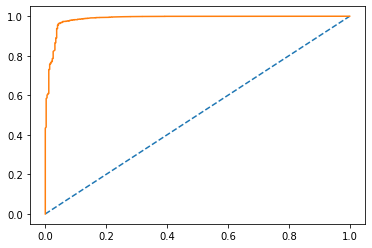

In [25]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, X_test_predictions_1)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_1, tpr_1)
pyplot.show()

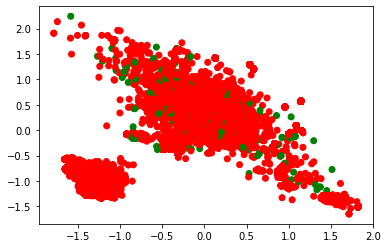

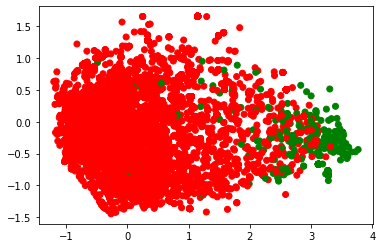

In [26]:
X = X_test / np.max(X_test)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)
points = np.arange(X.shape[0])
plt.scatter(X[points, 0], X[points, 1], color = ['red' if l == 1 else 'green' for l in y_test[points]])
plt.savefig('test_1.pdf')
plt.show()

result = torch.zeros(1, 70)


for i in H_list_lstm:
    result = torch.cat([result, i.cpu()], 0)

X_result = result.numpy()[1:]


X = X_result / np.max(X_result)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)
#points = np.arange(X.shape[0])

plt.scatter(X[points, 0], X[points, 1], color = ['red' if l == 1 else 'green' for l in y_test[points]])
plt.savefig('test_2.pdf')
plt.show()

#### Model-1

In [27]:
torch.manual_seed(SEED)

input_dim_1 = 307
input_dim_2 = 100
weight_dim_2 = 31
dropout_rate = 0.6
batch_size = 128
max_epochs = 10

model_1 = NeuralNetBinaryClassifier(
    Model_1_network,
    module__input_dim_1 = input_dim_1,
    module__input_dim_2 = input_dim_2,    
    module__weight_dim_2 = weight_dim_2,
    module__dropout_rate = dropout_rate,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_split = None,
    optimizer = torch.optim.Adam,
    iterator_train__shuffle = True,
    device = 'cuda'
)

pipe = Pipeline([
    ('model', model_1)
])

pipe.fit(X_train, y_train.astype(np.float))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  epoch    train_loss     dur
-------  ------------  ------
      1        0.1687  6.0029
      2        0.0455  5.9029
      3        0.0369  5.9223
      4        0.0311  5.8483
      5        0.0288  5.8286
      6        0.0248  5.7923
      7        0.0288  5.8010
      8        0.0237  8.9641
      9        0.0244  8.5189
     10        0.0241  9.7677


Pipeline(steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=Model_1_network(
    (dgcnn): DGCNN_network()
    (dropout): Dropout(p=0.6, inplace=False)
    (fc): Linear(in_features=9517, out_features=1, bias=True)
  ),
))])

In [28]:
H_list_model_1.clear()

X_test_predictions_2 = pipe.predict_proba(X_test)[:, 1]
model_evaluate(y_test, np.ones(len(y_test)))
model_evaluate(y_test, X_test_predictions_2)

Confusion matrix
[TN FP]
[FN TP]
[[    0   348]
 [    0 12815]]
F1-Score: 0.9866
ROC AUC: 0.5000
Confusion matrix
[TN FP]
[FN TP]
[[  217   131]
 [   15 12800]]
F1-Score: 0.9943
ROC AUC: 0.9753


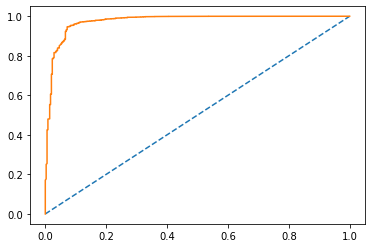

In [29]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, X_test_predictions_2)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_2, tpr_2)
pyplot.show()

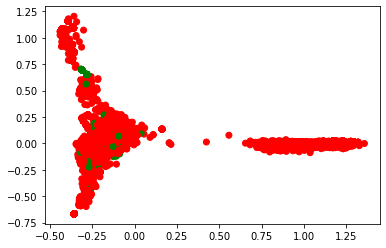

In [30]:
result = torch.zeros(1, 9517)
for i in H_list_model_1:
    result = torch.cat([result, i.cpu()], 0)

X_result = result.numpy()[1:]


X = X_result / np.max(X_result)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)
#points = np.arange(X.shape[0])

plt.scatter(X[points, 0], X[points, 1], color = ['red' if l == 1 else 'green' for l in y_test[points]])
plt.savefig('test_3.pdf')
plt.show()

#### Model-2

In [31]:
torch.manual_seed(SEED)

input_dim_1 = 307
input_dim_2 = 100
weight_dim_2 = 71
weight_dim_4 = 71
dropout_rate = 0.6
batch_size = 128
max_epochs = 10

model_2 = NeuralNetBinaryClassifier(
    Model_2_network,
    module__input_dim_1 = input_dim_1,
    module__input_dim_2 = input_dim_2,    
    module__weight_dim_2 = weight_dim_2,
    module__weight_dim_4 = weight_dim_4,
    module__dropout_rate = dropout_rate,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_split = None,
    optimizer = torch.optim.Adam,
    iterator_train__shuffle = True,
    device = 'cuda'
)

pipe = Pipeline([
    ('model', model_2)
])

pipe.fit(X_train, y_train.astype(np.float))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  epoch    train_loss     dur
-------  ------------  ------
      1        9.4686  7.5832
      2        0.0591  7.4245
      3        0.0426  7.4291
      4        0.0324  7.3994
      5        0.0286  7.4323
      6        0.0253  7.3890
      7        0.0230  7.4061
      8        0.0198  7.4130
      9        0.0188  7.4071
     10        0.0168  7.8699


Pipeline(steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=Model_2_network(
    (dgcnn_1): DGCNN_network()
    (dropout): Dropout(p=0.6, inplace=False)
    (dgcnn_2): DGCNN_network()
    (fc): Linear(in_features=43594, out_features=1, bias=True)
  ),
))])

In [32]:
H_list_model_2.clear()

X_test_predictions_3 = pipe.predict_proba(X_test)[:, 1]
model_evaluate(y_test, np.ones(len(y_test)))
model_evaluate(y_test, X_test_predictions_3)

Confusion matrix
[TN FP]
[FN TP]
[[    0   348]
 [    0 12815]]
F1-Score: 0.9866
ROC AUC: 0.5000
Confusion matrix
[TN FP]
[FN TP]
[[  241   107]
 [   30 12785]]
F1-Score: 0.9947
ROC AUC: 0.9664


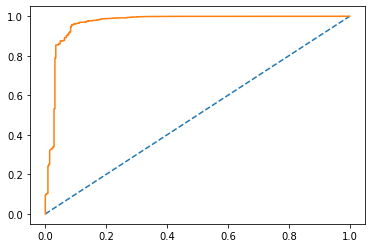

In [33]:
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, X_test_predictions_3)
pyplot.plot([0, 1], [0, 1], linestyle = '--')
pyplot.plot(fpr_3, tpr_3)
pyplot.show()

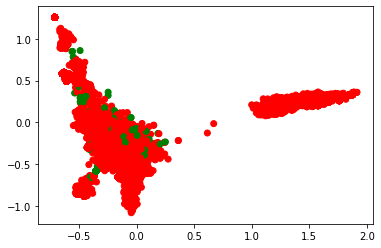

In [ ]:
result = torch.zeros(1, 43594)

for i in H_list_model_2:
    result = torch.cat([result, i.cpu()], 0)

X_result = result.numpy()[1:]


X = X_result / np.max(X_result)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)
#points = np.arange(X.shape[0])

plt.scatter(X[points, 0], X[points, 1], color = ['red' if l == 1 else 'green' for l in y_test[points]])
plt.savefig('test_4.pdf')
plt.show()

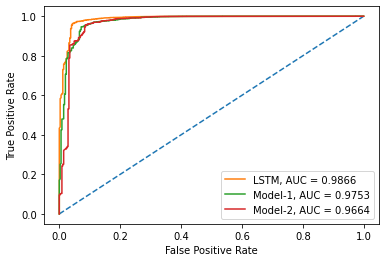

In [34]:
pyplot.plot([0, 1], [0, 1], linestyle = '--')
auc_1 = roc_auc_score(y_test, X_test_predictions_1)
pyplot.plot(fpr_1, tpr_1, label = f'LSTM, AUC = {auc_1:.4f}')
auc_2 = roc_auc_score(y_test, X_test_predictions_2)
pyplot.plot(fpr_2, tpr_2, label = f'Model-1, AUC = {auc_2:.4f}')
auc_3 = roc_auc_score(y_test, X_test_predictions_3)
pyplot.plot(fpr_3, tpr_3, label = f'Model-2, AUC = {auc_3:.4f}')
plt.legend(loc = 4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_i.pdf')
pyplot.show()